# Part 2: Coding Challenge

Lets import my custom modules that are defined to make the project as modular as possible.

In [1]:
from utils.data import (
    CellDataset, 
    load_ann_data, 
    to_categorical,
    generate_negative_samples,
)

from utils.model import FusionModel, UnifiedMultiModalClassifier, VanillaClassifier

from utils.trainer import PretrainTrainer, ClassificationTrainer, VanillaTrainer

from utils.loss import ContrastiveLoss

Also we need to import other libraries and tools required to do analysis and training

In [ ]:
import os
import umap
import optuna
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scanpy as sc     # A toolkit for analyzing single-cell gene expression data
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Data Prepration

### Loading

In [3]:
adata = load_ann_data(
    census_version = "2023-12-15",
    emb_names = ["geneformer"],
    obs_column_names=["cell_type", "donor_id", "sex"],
    organism="homo_sapiens",
)
adata

2025-03-04 21:08:13,762 - INFO - Loaded 31780 cells with 60664 genes.
2025-03-04 21:08:13,762 - INFO - Metadata columns: ['cell_type', 'donor_id', 'sex', 'tissue_general']
2025-03-04 21:08:13,763 - INFO - Available embeddings: ['geneformer']


AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'donor_id', 'sex', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'geneformer'

### Data Overview & Preprocessing

Now lets plot UMAP of the data for the deliverable part of the project.

In [4]:
adata.obs.cell_type.value_counts()

cell_type
oligodendrocyte                                        10924
cerebellar granule cell                                 8678
microglial cell                                         2562
oligodendrocyte precursor cell                          2036
GABAergic neuron                                        1744
astrocyte                                               1557
mural cell                                              1076
capillary endothelial cell                              1072
glutamatergic neuron                                     996
endothelial cell of artery                               336
differentiation-committed oligodendrocyte precursor      306
vascular associated smooth muscle cell                   158
leukocyte                                                146
central nervous system macrophage                        110
neuron                                                    52
ependymal cell                                            27
Name: count, d

Information on number of cells in the data

| Cell Type                                           | Count  |
|-----------------------------------------------------|--------|
| oligodendrocyte                                    | 10924  |
| cerebellar granule cell                            | 8678   |
| microglial cell                                    | 2562   |
| oligodendrocyte precursor cell                     | 2036   |
| GABAergic neuron                                   | 1744   |
| astrocyte                                         | 1557   |
| mural cell                                        | 1076   |
| capillary endothelial cell                        | 1072   |
| glutamatergic neuron                              | 996    |
| endothelial cell of artery                        | 336    |
| differentiation-committed oligodendrocyte precursor | 306    |
| vascular associated smooth muscle cell           | 158    |
| leukocyte                                         | 146    |
| central nervous system macrophage                | 110    |
| neuron                                           | 52     |
| ependymal cell                                   | 27     |


Now we can plot the UMAP using geneformer embeddings and color them based on the cell types!

... storing 'cell_type' as categorical
... storing 'donor_id' as categorical
... storing 'sex' as categorical
... storing 'tissue_general' as categorical


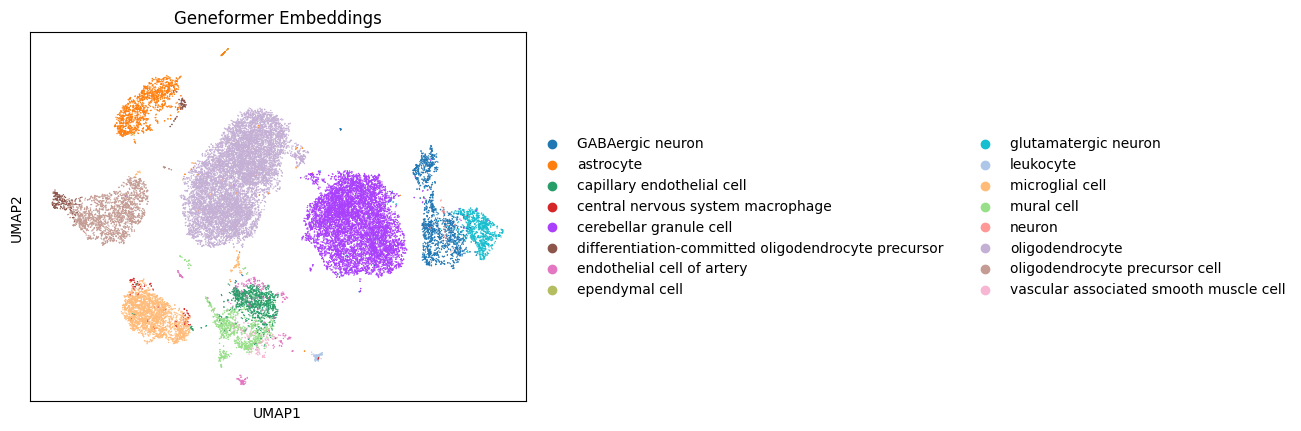

In [5]:
# Compute the nearest neighbor graph using the precomputed "geneformer" embeddings.
# This step identifies similar cells based on their Geneformer representations,
# which will be used later by UMAP to generate a low-dimensional (2D) visualization.
sc.pp.neighbors(adata, use_rep="geneformer")

# Compute the UMAP embedding based on the neighbor graph.
# UMAP reduces the high-dimensional gene expression space into a 2D space for visualization.
sc.tl.umap(adata)

# Plot UMAP based on embeddings and color them by cell type.
sc.pl.umap(adata, color="cell_type", title="Geneformer Embeddings")

In [6]:
print(f'There are {adata.obs.cell_type.unique().shape[0]} different cell types in the dataset.')
adata.obs.cell_type.value_counts()

There are 16 different cell types in the dataset.


cell_type
oligodendrocyte                                        10924
cerebellar granule cell                                 8678
microglial cell                                         2562
oligodendrocyte precursor cell                          2036
GABAergic neuron                                        1744
astrocyte                                               1557
mural cell                                              1076
capillary endothelial cell                              1072
glutamatergic neuron                                     996
endothelial cell of artery                               336
differentiation-committed oligodendrocyte precursor      306
vascular associated smooth muscle cell                   158
leukocyte                                                146
central nervous system macrophage                        110
neuron                                                    52
ependymal cell                                            27
Name: count, d

We will pass the cell types as str in the model to tokenize generate text embedding during forward pass.

In the last step of the preprocessing let transform 'sex' and 'donor_id' (target class) into categorical features.

In [7]:
# Transform 'sex' into a binary categorical feature
adata.obs, sex_mapping = to_categorical(adata.obs, "sex")

# Transform 'donor_id' into a categorical feature with more than two labels
adata.obs, class_mapping = to_categorical(adata.obs, "donor_id")

# Verify the transformation
print('Sex:', adata.obs["sex"].unique())
print('Donor_ID:', adata.obs["donor_id"].unique())

Sex: [1 0]
Donor_ID: [10  5  3  9  0  6  8  7  4  2 13 11  1 12]


In the last step of data prepration we need to gather the data as a unified dataset in PyTorch to be able to use it in the training phase. Also, we split it on train and test set to evaluate our model performance.

In [8]:
# shuffling dataset to ensure we have form all classes in both train and test
df = pd.DataFrame({
    "cell_type": adata.obs["cell_type"].values,
    "sex": adata.obs["sex"].values,
    "donor_id": adata.obs["donor_id"].values,
    "geneformer_embeddings": adata.obsm["geneformer"].tolist()
})

# Shuffle dataset while maintaining correspondence between features
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define split sizes
TRAIN_SIZE = int(0.8 * df.shape[0])

# Split shuffled data into train and test
data = {
    "cell_type": df["cell_type"][:TRAIN_SIZE].values,
    "sex": df["sex"][:TRAIN_SIZE].values,
    "geneformer_embeddings": df["geneformer_embeddings"][:TRAIN_SIZE].copy(),
    "donor_id": df["donor_id"][:TRAIN_SIZE].values
}

# Test set
data_test = {
    "cell_type": df["cell_type"][TRAIN_SIZE:].values,
    "sex": df["sex"][TRAIN_SIZE:].values,
    "geneformer_embeddings": df["geneformer_embeddings"][TRAIN_SIZE:].copy().reset_index(drop=True),
    "donor_id": df["donor_id"][TRAIN_SIZE:].values
}

# Create a PyTorch dataset and dataloader
cell_dataset = CellDataset(data)    # Create an instance of the dataset
cell_dataloader = DataLoader(cell_dataset, batch_size=32, shuffle=True)

test_dataset = CellDataset(data_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Test first batch to ensure everything is working correctly
for batch in cell_dataloader:
    print(batch)
    break

{'cell_type': ['neuron', 'oligodendrocyte', 'capillary endothelial cell', 'astrocyte', 'cerebellar granule cell', 'oligodendrocyte', 'oligodendrocyte', 'oligodendrocyte precursor cell', 'astrocyte', 'cerebellar granule cell', 'cerebellar granule cell', 'oligodendrocyte', 'cerebellar granule cell', 'oligodendrocyte', 'GABAergic neuron', 'oligodendrocyte', 'oligodendrocyte', 'oligodendrocyte precursor cell', 'cerebellar granule cell', 'oligodendrocyte', 'glutamatergic neuron', 'oligodendrocyte precursor cell', 'oligodendrocyte', 'oligodendrocyte', 'oligodendrocyte', 'oligodendrocyte', 'oligodendrocyte precursor cell', 'microglial cell', 'oligodendrocyte', 'cerebellar granule cell', 'microglial cell', 'cerebellar granule cell'], 'sex': tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0]), 'geneformer_embeddings': tensor([[-0.1553, -1.1797,  0.0447,  ...,  0.3398, -1.7422, -1.2109],
        [ 0.3809,  0.8867,  0.2324,  ..., -0.398

## Multimodal Integration & Multimodal Pretraining

I have all my models implemented in the `utils.model` as I wanted to ensure a clean and modular reusable code. My models are as follows:

- **Text Encoder**: Contains the pretrained text encoder. It will transform `cell_type` labels into a single vector representing the label.
- **CrossModalAttention**: An internal module used by parent module as a component to integrate different modalities by applying MultiHeadAttenion and Perciever Resmaple to map them to a new shared space.
- **FusionModel**: This a intermediate model that is used in the pretraining phase to generate embeddings for modalities in the new shared space and optimizing it using a contrastive learning loss.
- **UnifiedMultiModalClassifier**: An extension of FusionModel that can load pretrained weights from the pretraining phase and accept additional features (e.g. sex feature) to train out classifier for `donor_id` predicition.

### FusionModel
The primary and most important class in `model.py` is the `FusionModel` which apply perciever resampler and attention on both text and gene embeddings to map them into a shared space. The model:
1. Gets two modality with different dimensions
2. Resamples them into a fixed sequence with dimension of $h$.
3. Applies MultiHeadAttion to both modalities to reweight them by attending to each other.

-----

**Question: Justify your choice of key, query, and value in cross-attention modules.**

The choice of key, query, and value in cross-attention modules is based on the idea of asking a question by querying a vector. In other words, we aim to reweight one set of vectors by attending to another.

In my design, I applied cross-attention to both modalities by using the attention mechanism in two ways:
1.	Treating the text embeddings as the query and the gene embeddings as the key/value.
2.	Reversing the roles, with the gene embeddings as the query and the text embeddings as the key/value.

This bidirectional approach allows both modalities to influence each other effectively.

In [9]:
def nevative_sampler_collate(batch):
    negative_samples = generate_negative_samples(batch, "cell_type", df.cell_type.unique())
    batch = batch + negative_samples
    return {
        "cell_type": [item["cell_type"] for item in batch],
        "geneformer_embeddings": torch.stack([item["geneformer_embeddings"].clone().detach() for item in batch]),
    }
    
contrastive_loader = DataLoader(
    cell_dataset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=nevative_sampler_collate,
)

contrastive_test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=nevative_sampler_collate,
)

### Hyperparameter Estimation

Hyperparameter tuning uses [Optuna](https://optuna.org/) to systematically explore different model configurations. By running 50 intelligent trials, the algorithm searches for the optimal combination of model settings that minimizes validation loss after 2 epochs, balancing computational efficiency with performance optimization. I optimize the following hyperparameters:

- `num_latent_vectors`: Number of latent vectors in the model
  - Explored values: [1, 2, 4, 8, 16, 32, 64]
  - Helps control the model's capacity to capture complex representations

- `attention_heads`: Number of attention heads in the multi-head attention mechanism
  - Explored values: [1, 2, 4, 8]
  - Allows the model to focus on different aspects of the input simultaneously

- `hidden_size`: Dimensionality of the hidden layers
  - Explored range: 128 to 512 (step of 128)
  - Dynamically adjusted to ensure compatibility with attention heads
  - Determines the model's representational capacity

- `dropout`: Regularization rate to prevent overfitting
  - Explored range: 0.1 to 0.5
  - Helps in reducing model complexity and improving generalization

- `learning_rate`: Optimization step size for the Adam optimizer
  - Explored range: 1e-5 to 1e-3 (log-scaled search)
  - Smaller values ensure more stable but slower convergence

In [ ]:
# Define objective function for parameters
def objective(trial):
    # Defining hyperparameters that we need to tune!
    num_latent_vectors = trial.suggest_categorical("num_latent_vectors", [1, 2, 4, 8, 16, 32, 64])
    attention_heads = trial.suggest_categorical("attention_heads", [1, 2, 4, 8])
    hidden_size = trial.suggest_int("hidden_size", 128, 512, step=128)
    # We need to make sure: head_dim * num_heads == embed_dim
    # Round to nearest divisible value
    hidden_size = (hidden_size // attention_heads) * attention_heads  
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    # Set log to True to ensure balance search for LR
    # Smaller values (like 1e-5, 2e-5) change the model behavior less than larger values (like 5e-4, 1e-3).
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    model = FusionModel(
        text_encoder_id="dmis-lab/biobert-v1.1",
        gene_input_dim=len(df['geneformer_embeddings'][0]),  
        hidden_size=hidden_size,
        freeze_text_encoder=True,
        attention_heads=attention_heads,
        num_latent_vectors=num_latent_vectors,
        dropout=dropout,
    )

    # Defining loss function, optimizer, and scheduler
    contrastive_loss = ContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(contrastive_loader))

    # Initialize my custom trainer
    pretrain_trainer = PretrainTrainer(
        model=model, 
        loss_fn=contrastive_loss, 
        optimizer=optimizer, 
        scheduler=scheduler
    )

    # Train the model for a small number of epochs (for efficiency)
    pretraining_metrics = pretrain_trainer.train(
        train_loader=contrastive_loader,
        val_loader=test_dataloader,
        num_epochs=2,           # More epochs results in more accurate estimation
    )

    # Return the validation loss
    return pretraining_metrics["validation"][-1]["val_loss"]  

# Run Bayesian Optimization
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)

Since running last cell takes too long I just ran it once and used the optimal values. However by running it again you should be able to search for optimal parameters again.

In [9]:
# hypterparameters = {
#     'attention_heads': study.best_params['attention_heads'],
#     'num_latent_vectors': study.best_params['num_latent_vectors'],
#     'hidden_size': study.best_params['hidden_size'],
#     'dropout': study.best_params['dropout'],
#     'learning_rate': study.best_params['learning_rate']
# }

# Setting the founded parameters hardcoded to run the code faster. 
# The values are based on trying it once.

hypterparameters = {
    'attention_heads': 2,
    'num_latent_vectors': 16,
    'hidden_size': 384,
    'dropout': 0.3,
    'learning_rate': 3e-05
}

Now we have found the optimal hyperparamaters, lets use them to pretrain our FusionModel in order to modality alignment

In [ ]:
model = FusionModel(
        text_encoder_id = "dmis-lab/biobert-v1.1",
        gene_input_dim = len(df['geneformer_embeddings'][0]),  # Geneformer embeddings shape
        hidden_size = hypterparameters['hidden_size'],
        freeze_text_encoder = True,
        attention_heads= hypterparameters['attention_heads'],
        num_latent_vectors=hypterparameters['num_latent_vectors'],
        dropout=hypterparameters['dropout']
    )
contrastive_loss = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hypterparameters['learning_rate'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(contrastive_loader))

pretrain_trainer = PretrainTrainer(
    model=model, 
    loss_fn=contrastive_loss, 
    optimizer=optimizer, 
    scheduler=scheduler
)

pretraining_metrics = pretrain_trainer.train(
    train_loader=contrastive_loader,
    val_loader=contrastive_test_loader,
    num_epochs=2,
)

Epoch 2/2: 100%|██████████| 1589/1589 [02:15<00:00, 11.70it/s, loss=0.0152] 


Now let's save the pretrained weights to use it later!

In [ ]:
pretrain_trainer.save_model('weights/pretrained.pth')

Let's check if the pretrained model is working as expected and whether two embeddings are falling same place next to each other.

In [13]:
test_df = pd.DataFrame(data_test)
test_df

,cell_type,sex,geneformer_embeddings,donor_id
0,oligodendrocyte,1,"[-0.01177978515625, 0.84765625, 1.3203125, 0.9...",9
1,oligodendrocyte,0,"[-0.255859375, 1.4609375, 1.0546875, 0.5273437...",6
2,cerebellar granule cell,1,"[0.671875, -0.27734375, 1.109375, 1.0078125, 0...",13
3,oligodendrocyte,0,"[-0.099609375, 1.75, 1.2890625, 1.15625, 0.244...",6
4,oligodendrocyte,0,"[-0.333984375, 1.421875, 0.9609375, 1.1796875,...",6
...,...,...,...,...
6351,oligodendrocyte,1,"[0.134765625, 1.1640625, 1.3671875, 1.2421875,...",4
6352,oligodendrocyte,0,"[0.1962890625, 1.2734375, 0.48828125, 1.1875, ...",6
6353,oligodendrocyte,1,"[-0.462890625, 0.48828125, 1.3359375, 0.287109...",10
6354,cerebellar granule cell,0,"[-0.083984375, 0.4609375, 0.390625, 0.4765625,...",1


In [14]:
def balanced_sample(df, target_column, n_per_class=None):
    """
        Sample from a DataFrame such that each class has the same number of samples.
    """
    value_counts = df[target_column].value_counts()
    
    if n_per_class is None:
        n_per_class = value_counts.min()
    elif n_per_class > value_counts.min():
        print(f"Warning: n_per_class ({n_per_class}) is greater than the minimum class frequency ({value_counts.min()})")
        print(f"Using {value_counts.min()} instead")
        n_per_class = value_counts.min()
    
    # Sample equal number from each class
    samples = []
    for value in value_counts.index:
        class_df = df[df[target_column] == value]
        samples.append(class_df.sample(n_per_class, random_state=42))
    
    balanced_df = pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df


In [15]:
samples = balanced_sample(test_df, "cell_type", n_per_class=2)
samples.cell_type.value_counts()

cell_type
GABAergic neuron                                       2
astrocyte                                              2
capillary endothelial cell                             2
central nervous system macrophage                      2
cerebellar granule cell                                2
differentiation-committed oligodendrocyte precursor    2
endothelial cell of artery                             2
ependymal cell                                         2
glutamatergic neuron                                   2
leukocyte                                              2
microglial cell                                        2
mural cell                                             2
neuron                                                 2
oligodendrocyte                                        2
oligodendrocyte precursor cell                         2
vascular associated smooth muscle cell                 2
Name: count, dtype: int64

In [ ]:
# Inference and genearate embeddings and store them in a list
triplets = []
for i, row in samples.iterrows():
    label = row['cell_type']
    device = next(model.parameters()).device
    input_ = ([label], torch.tensor(row['geneformer_embeddings']).unsqueeze(0).to(device))
    emb1, emb2 = model(input_)
    triplets.append([label, emb1.detach().cpu()[0], emb2.detach().cpu()[0]])

In [ ]:
def plot_triplet_umap(triplets):
    """
    Reduces dimensionality of triplet embeddings (emb1, emb2) using UMAP and plots them.

    Parameters:
    - triplets: List of tuples (label, emb1, emb2), where:
      - label: class/category
      - emb1: first modality embedding
      - emb2: second modality embedding
    """
    labels, emb1_list, emb2_list = zip(*triplets)

    # Convert to NumPy arrays
    emb1_array = np.array(emb1_list)
    emb2_array = np.array(emb2_list)

    # Stack embeddings together for joint UMAP reduction
    all_embeddings = np.vstack([emb1_array, emb2_array])

    # Reduce to 2D using UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(all_embeddings)

    # Separate reduced embeddings
    emb1_reduced = reduced_embeddings[:len(emb1_list)]
    emb2_reduced = reduced_embeddings[len(emb1_list):]

    # Plot setup
    plt.figure(figsize=(10, 7))
    sns.set(style="whitegrid")

    # Unique classes for color mapping
    unique_classes = np.unique(labels)
    palette = sns.color_palette("husl", len(unique_classes))
    class_to_color = {cls: palette[i] for i, cls in enumerate(unique_classes)}

    # Plot embeddings with corrected color and marker
    for i, cls in enumerate(labels):
        plt.scatter(*emb1_reduced[i], color=class_to_color[cls], marker='o', label=cls if i == 0 else "", alpha=0.7)  # emb1 (o)
        plt.scatter(*emb2_reduced[i], color=class_to_color[cls], marker='s', label=cls if i == 0 else "", alpha=0.7)  # emb2 (s)

    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.title("UMAP Projection of Multi-modal Embeddings")

    # Custom legend for markers
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Text Embedding'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Gene Embedding')
    ]
    plt.legend(handles=legend_elements, title="Modality", loc="lower right", bbox_to_anchor=(1.15, 1))
    plt.savefig('logs/pretraining/modality_alignment_umap.png', dpi=600, bbox_inches='tight', format='png')
    plt.show()

/Users/pouyannahed/opt/anaconda3/envs/czbiohub/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


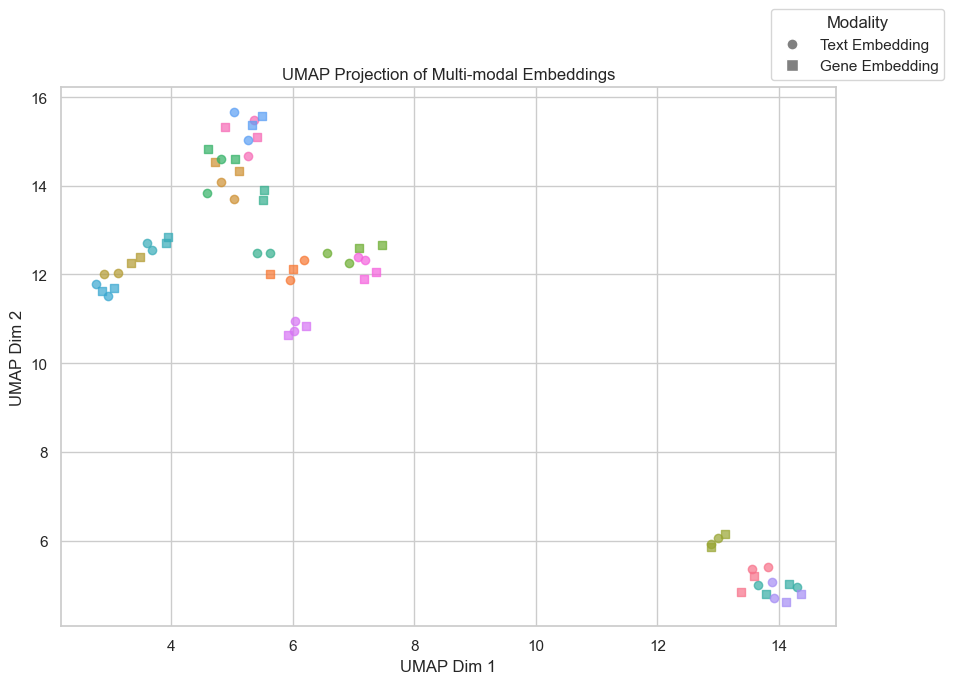

In [18]:
plot_triplet_umap(triplets)

In the plot modals are represented by different markers (cirlce for text and square for gene) and colors are unique for each cell_type. We can see that the model is able to encode and have a shared space pretty well! The distances are not ideal but still we can cleary see the separation between classes.

### Cross Attention Visualization
For the cross-attention visualization, I use the output of the Perceiver Resampler for the bi-directional attention between the two modalities. Since my resampler employs 16 latent vectors, each data modality results in a sequence of 16 tokens representing information. Consequently, my cross-attention heatmap is a 16×16 matrix, where each cell indicates the attention of token i from one modality to token j in the other modality.

Moreover, because the attention mechanism is bi-directional—by swapping the query and key/value roles—we obtain two distinct heatmaps per sample. The left heatmap illustrates attention from the text modality to the gene data, while the right heatmap depicts the attention from the gene sequence to the text sequence.

One interesting observation is that the gene-to-text attention heatmap appears slightly brighter. This likely results from the fact that each gene latent vector attends to the entire text sequence, whereas the text label conveys a unified semantic meaning. In contrast, genes may carry distinct meanings for different segments, leading to a more dispersed attention pattern.

In [16]:
def visualize_cross_attention(model, dataloader, num_samples=3, save_path=None):
    """
    Visualize cross-attention weights between text and gene modalities.
    
    Args:
        model: Trained FusionModel or UnifiedMultiModalClassifier instance
        dataloader: DataLoader with samples to visualize
        num_samples: Number of samples to visualize
        save_path: Optional path to save the visualizations
    """
    # Ensure model is in evaluation mode
    model.eval()
    device = next(model.parameters()).device
    
    # Get a batch of data
    batch = next(iter(dataloader))
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    
    # Extract only the number of samples we want to visualize
    text_input = batch["cell_type"][:num_samples]
    gene_data = batch["geneformer_embeddings"][:num_samples]
    
    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 5*num_samples))
    
    # If we only have one sample, make axes 2D
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        # Use the model's forward method with return_attn=True
        input_data = (text_input, gene_data)
        (text_pooled, gene_pooled), (text_to_gene_attn, gene_to_text_attn) = model(input_data, return_attn=True)
    
        # For each sample, plot both directions of attention
        for i in range(num_samples):
            sample_cell_type = text_input[i]
            if isinstance(sample_cell_type, list):
                sample_cell_type = sample_cell_type[0]  # Get first item if it's a list
            
            # Plot text → gene attention (how cell type attends to genes)
            ax1 = axes[i, 0]
            attention_map = text_to_gene_attn[i].cpu().numpy()
            
            # Plot text → gene attention heatmap
            sns.heatmap(
                attention_map, 
                ax=ax1, 
                cmap='viridis', 
                cbar=True
            )
            ax1.set_title(f"Sample {i+1}: Text → Gene Attention\nCell Type: {sample_cell_type}")
            ax1.set_xlabel("Gene Latent Vectors")
            ax1.set_ylabel("Text Latent Vectors")
            
            # Plot gene → text attention (how genes attend to cell type)
            ax2 = axes[i, 1]
            attention_map = gene_to_text_attn[i].cpu().numpy()
            
            # Plot gene → text attention heatmap
            sns.heatmap(
                attention_map, 
                ax=ax2, 
                cmap='viridis', 
                cbar=True
            )
            ax2.set_title(f"Sample {i+1}: Gene → Text Attention\nCell Type: {sample_cell_type}")
            ax2.set_xlabel("Text Latent Vectors")
            ax2.set_ylabel("Gene Latent Vectors")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return (text_to_gene_attn, gene_to_text_attn)


I have included the commented model creation below to use the pretrained weight and visualize the cross attention weights

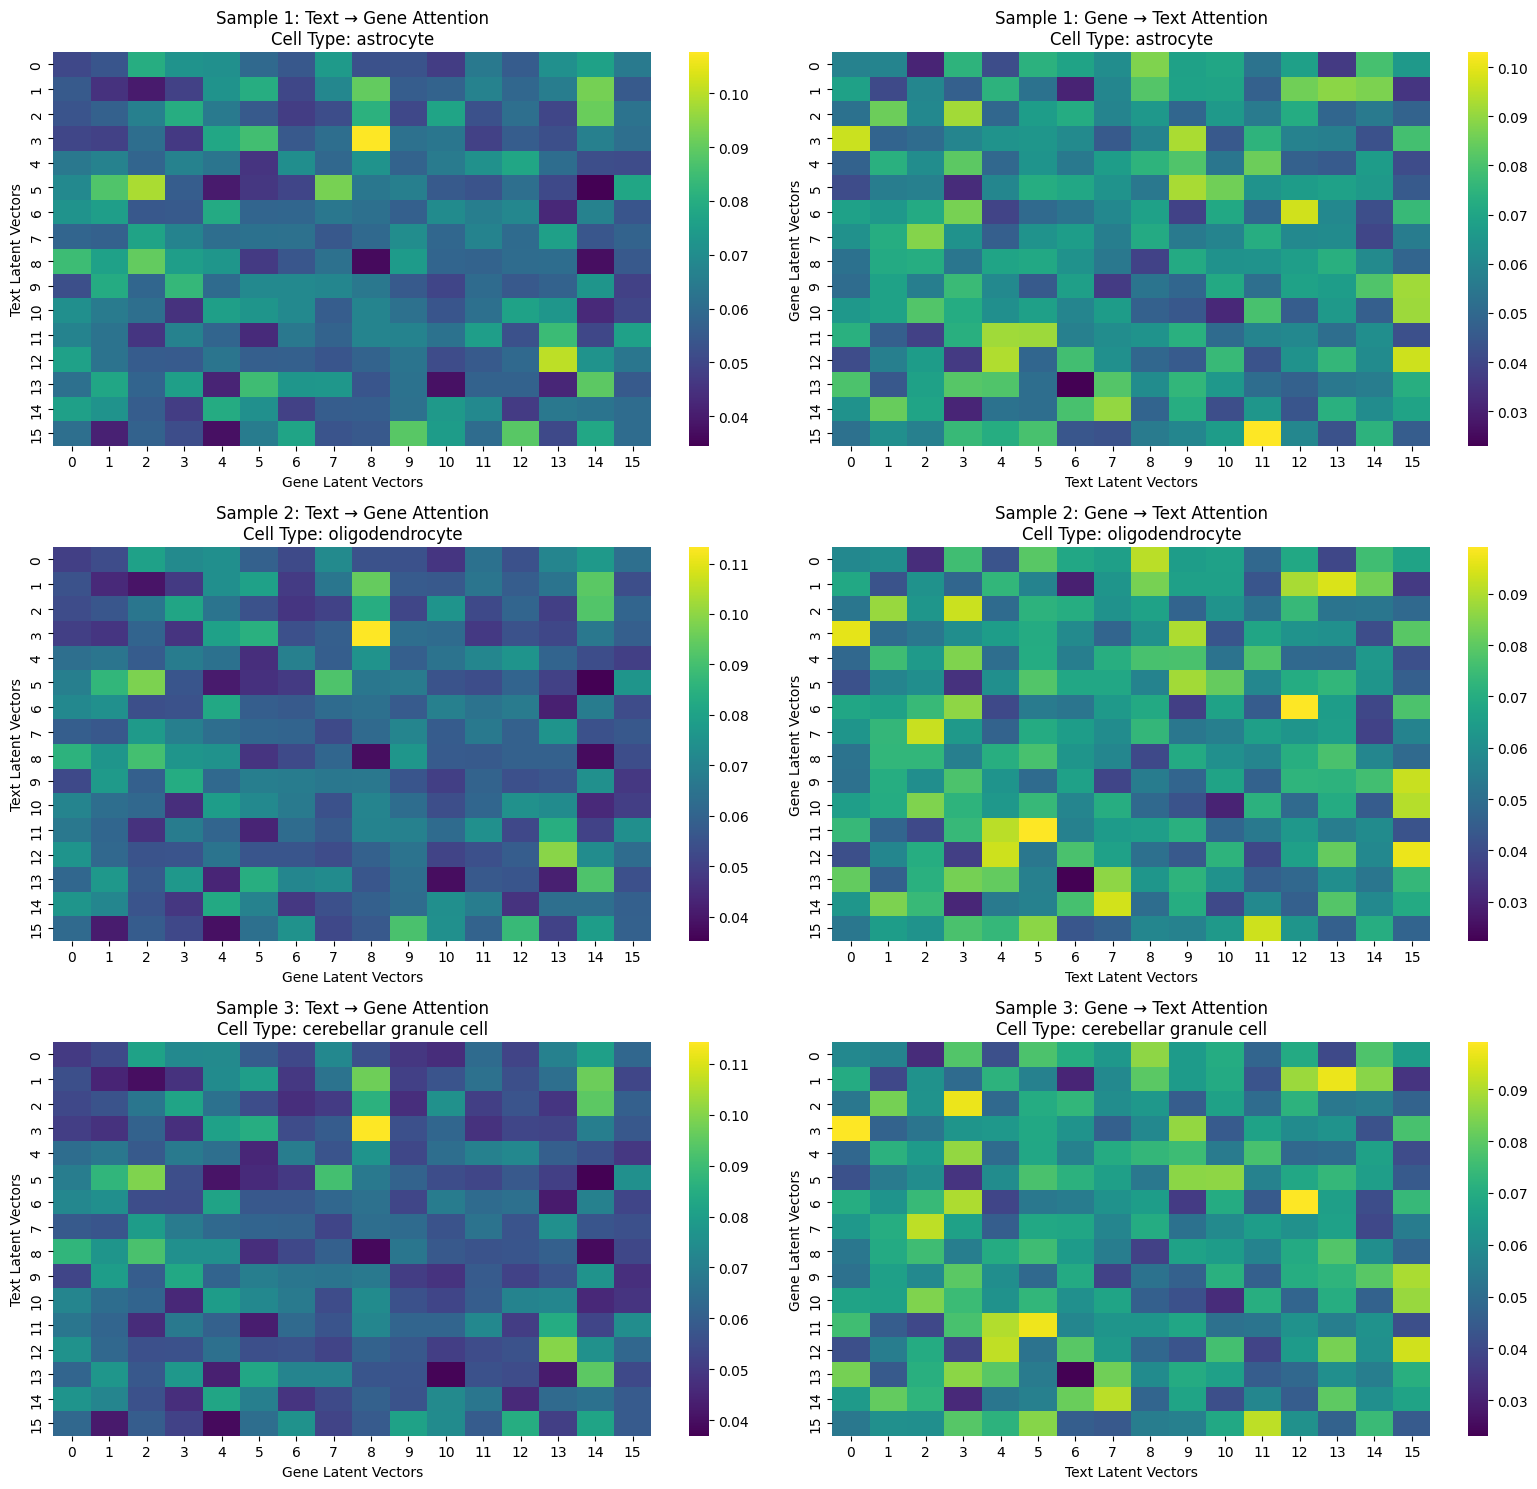

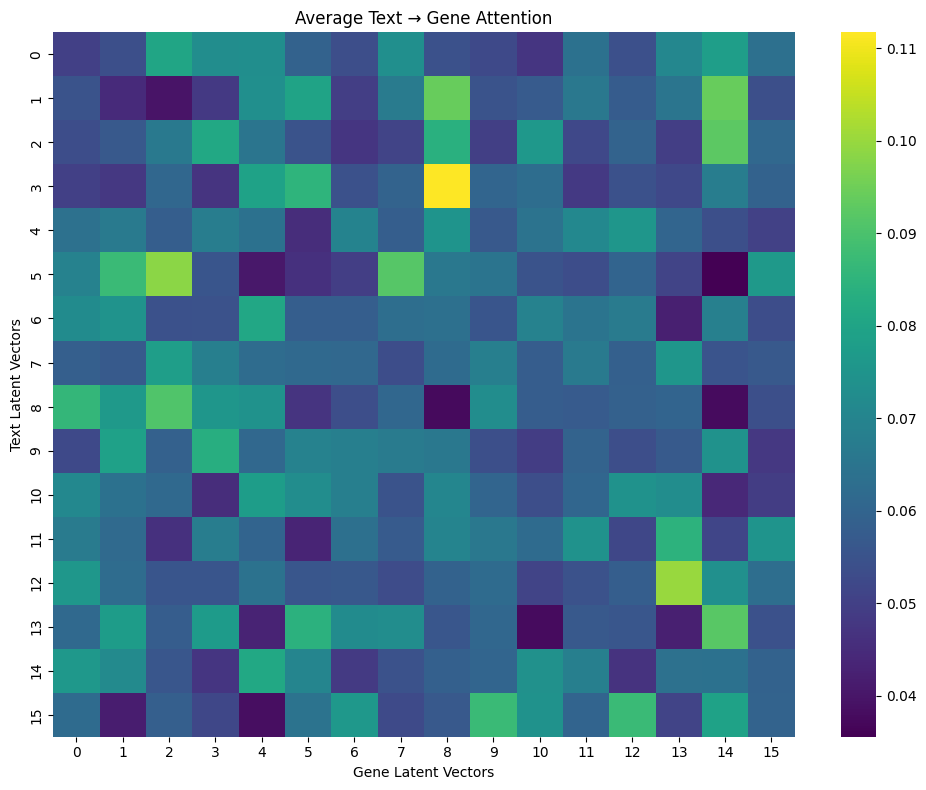

In [ ]:
# Remove the following comments in order to load the model from pretrained weights
# model = FusionModel(
#     text_encoder_id="dmis-lab/biobert-v1.1",
#     gene_input_dim=len(df['geneformer_embeddings'][0]),
#     hidden_size=hypterparameters['hidden_size'],
#     attention_heads=hypterparameters['attention_heads'],
#     num_latent_vectors=hypterparameters['num_latent_vectors'],
#     dropout=hypterparameters['dropout'],
#     freeze_text_encoder=True,
# )
# model.load_state_dict(torch.load('weights/pretrained.pth'))

# Visualize cross-attention for a few samples
attn_weights = visualize_cross_attention(
    model=model, 
    dataloader=test_dataloader,
    num_samples=3,
    save_path="logs/pretraining/cross_attention_visualization.png"
)

# You can also further analyze the attention patterns
text_to_gene_attn, gene_to_text_attn = attn_weights

# For example, visualize average attention across all samples
avg_text_to_gene = text_to_gene_attn.mean(dim=0).cpu().numpy()
plt.figure(figsize=(12, 8))
sns.heatmap(avg_text_to_gene, cmap='viridis')
plt.title("Average Text → Gene Attention")
plt.xlabel("Gene Latent Vectors")
plt.ylabel("Text Latent Vectors")
plt.tight_layout()
plt.savefig("logs/pretraining/avg_text_to_gene_attention.png", dpi=300)
plt.show()

## Train Classifier

Now lets initialize a model for classification and use our pretrained model to classify the `donor_id`. For this task I have designed and implemented a Module called `UnifiedMultiModalClassifier` in the `model.py` which is exntension of the last `FusionModel` with a classification head that classifies and predicts `donor_id`.

`UnifiedMultiModalClassifier` along with `ClassificationTrainer` incoporate Adversarial Training to mitigate effect of cofounding variables and train a robust classifier. In order to implement the adversarial training for the classifier, I could do it two way:
1. Use a simple classifier module within multi modal classifier and use feature in the middle of forward of `UnifiedMultiModalClassifier`.
2. Use gradient reversion to predict the feature

I used the second approach as it was easier and more compatible with my classes architecture and lead to a better modular design.

In [ ]:
# Define objective function for classifier hyperparameter tuning
def objective(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_float("classifier_learning_rate", 1e-5, 1e-3, log=True)
    lambda_adv = trial.suggest_float("lambda_adv", 0.01, 1.0, log=True) # Adversarial weight parameter
    
    # Create classifier with the trial hyperparameters
    classifier = UnifiedMultiModalClassifier(
        class_num=df['donor_id'].unique().shape[0],  # Number of unique classes
        # We need to keep the pretrained model and the hyperparameters to load weights
        hidden_size = hypterparameters['hidden_size'],
        attention_heads= hypterparameters['attention_heads'],
        num_latent_vectors=hypterparameters['num_latent_vectors'],
        dropout=hypterparameters['dropout'],
        lambda_adv=lambda_adv,
        freeze_text_encoder = True,
    )
    
    # Load pretrained weights
    classifier.from_pretrained('weights/pretrained.pth')
    
    # Setup optimizer, losses, and scheduler
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    ce_loss = torch.nn.CrossEntropyLoss()  # Main task loss
    bce_loss = torch.nn.BCEWithLogitsLoss()  # Adversarial loss for sex prediction
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(cell_dataloader))
    
    # Initialize classification trainer with adversarial training
    classification_trainer = ClassificationTrainer(
        model=classifier,
        optimizer=optimizer,
        loss_fn=ce_loss,
        adv_loss_fn=bce_loss,
        lambda_adv=lambda_adv,
        scheduler=scheduler,
        use_adversarial=True
    )
    
    # Train the model for a small number of epochs
    try:
        classifier_train_metrics = classification_trainer.train(
            train_loader=cell_dataloader,
            val_loader=test_dataloader,
            num_epochs=2,  # Reduced for faster trials
            logging_steps=20,
        )
        
        # Return the validation loss
        return classifier_train_metrics["validation"][-1]["val_loss"]
    except Exception as e:
        # Log the error and return a high loss value to avoid this parameter combination
        print(f"Trial failed with error: {e}")
        return float('inf')

# Run the hyperparameter optimization
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=30)  # Adjust number of trials as needed

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Visualize optimization results
try:
    optuna.visualization.plot_optimization_history(study)
    optuna.visualization.plot_param_importances(study)
    optuna.visualization.plot_slice(study)
except ImportError:
    print("Optuna visualization imports failed. Try installing plotly and matplotlib for visualization.")

# Save the best hyperparameters
best_params = study.best_params
print(f"Best validation loss: {study.best_value}")

Similar to the last hyperparameter tuning I used the same approach here. Ran the hyperparameter tuning once and used the values to hardcode the hyperparameters for the training.

In [ ]:
# classifier_hypterparameters = {
#     'classifier_learning_rate': best_params['classifier_learning_rate'],
#     'lambda_adv': best_params['lambda_adv']
# }

# Setting the founded parameters hardcoded to run the code faster.
classifier_hypterparameters = {
    'classifier_learning_rate': 3e-05,      # we can have different LR for classification
    'lambda_adv': 0.15,                     # weight for adversarial loss
}
hypterparameters.update(classifier_hypterparameters)

In [ ]:
classifier = UnifiedMultiModalClassifier(
    class_num=df['donor_id'].unique().shape[0],  # Number of unique classes
    hidden_size = hypterparameters['hidden_size'],
    freeze_text_encoder = True,
    attention_heads= hypterparameters['attention_heads'],
    num_latent_vectors=hypterparameters['num_latent_vectors'],
    dropout=hypterparameters['dropout'],
    lambda_adv=hypterparameters['lambda_adv'],
    use_adversarial=False,
)

# Load pretrained weights!
classifier.from_pretrained('weights/classifier.pth')

Epoch 3/3: 100%|██████████| 795/795 [01:04<00:00, 12.24it/s, loss=2.01]


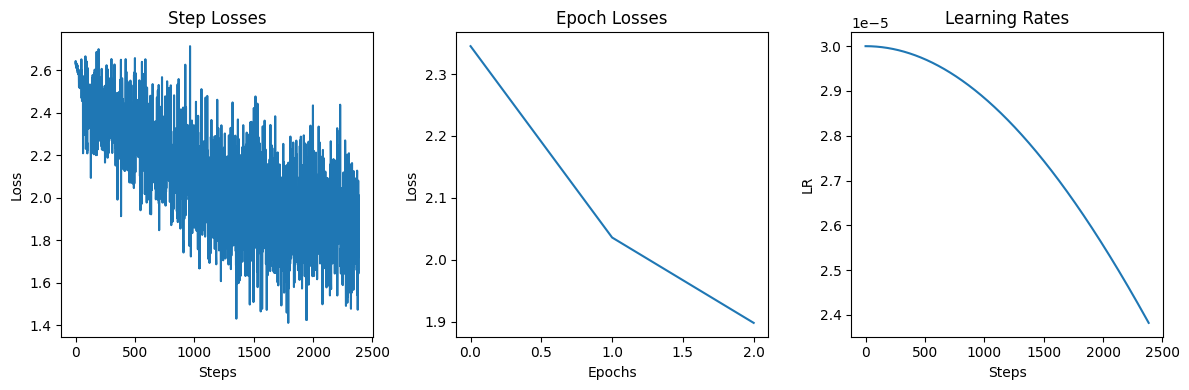

<Figure size 640x480 with 0 Axes>

In [12]:
# Create optimizers for both main model and adversarial components
optimizer = torch.optim.Adam(classifier.parameters(), lr=hypterparameters['classifier_learning_rate'])
ce_loss = torch.nn.CrossEntropyLoss()  # Main task loss
bce_loss = torch.nn.BCEWithLogitsLoss()  # Adversarial loss for sex prediction
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(cell_dataloader))

# Create the classification trainer with adversarial support
classification_trainer = ClassificationTrainer(
    model=classifier,
    optimizer=optimizer,
    loss_fn=ce_loss,
    adv_loss_fn=bce_loss,  # Add adversarial loss function
    lambda_adv=hypterparameters['lambda_adv'],  # Weight for adversarial component
    scheduler=scheduler,
    use_adversarial=False  # Enable adversarial training
)

# Train the model with adversarial components
classifier_train_metrics = classification_trainer.train(
    cell_dataloader,
    num_epochs=3,
    val_loader=test_dataloader,
)

# After training, you can visualize both main and adversarial metrics
classification_trainer.plot_training_metrics(save_path="./logs/classification/adversarial_training_results.png")

### Test Classifier

Now we have trained our classifier, lets test it on the test set to see the model performance.

In [10]:
def inference(model, dataloader, device=None):
    """
    Perform inference on the given dataloader and return the model predictions.
    """
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:    
            device = "cpu"
        device = torch.device(device)
    
    model.to(device)
    model.eval()  # Set model to evaluation mode (disable some modules like dropout)

    gt_labels = []
    predictions = []
    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(dataloader, total=len(dataloader)):
            # Convert cell_type strings to indices using the vocabulary mapping
            cell_type_list = batch["cell_type"]
            gene_data = batch["geneformer_embeddings"].to(device)
            if 'sex' in batch:
                sex = batch['sex'].to(device)
                input_ = (cell_type_list, gene_data, sex)
            else:
                input_ = (cell_type_list, gene_data)

            output = model(input_)
            predictions.append(output.cpu())  # Move to CPU for easier processing
            gt_labels.append(batch['labels'].cpu())  # Move to CPU for easier processing

    return torch.cat(predictions), torch.cat(gt_labels)  # Concatenate all predictions & labels

  0%|          | 0/199 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.31      0.16      0.21       439
           1       0.32      0.27      0.29       480
           2       0.25      0.05      0.08       288
           3       0.50      0.60      0.55       193
           4       0.35      0.51      0.42       663
           5       0.27      0.09      0.13       381
           6       0.46      0.54      0.50       687
           7       0.25      0.25      0.25       569
           8       0.38      0.53      0.44       544
           9       0.29      0.59      0.39       412
          10       0.00      0.00      0.00       201
          11       0.27      0.09      0.14       332
          12       0.38      0.29      0.33       359
          13       0.64      0.79      0.71       808

    accuracy                           0.40      6356
   macro avg       0.33      0.34      0.32      6356
weighted avg       0.37      0.40      0.36      6356

Model Accuracy: 39.600%


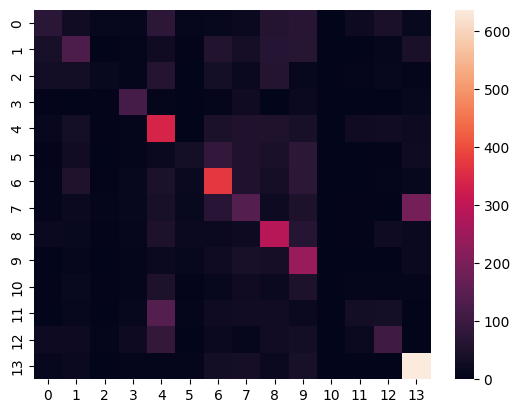

In [15]:
y_pred, y_true = inference(
    classifier,
    test_dataloader,
)
y_pred = F.softmax(y_pred, dim=1).argmax(1)

print(classification_report(y_true, y_pred, zero_division=0))
print('Model Accuracy: {:.3f}%'.format(accuracy_score(y_true, y_pred) * 100))

sns.heatmap(confusion_matrix(y_true, y_pred), 
            label=[class_mapping[i] for i in range(len(class_mapping))])
plt.show()

## Vanila Classifier (W/O Alignment)

One good question in the pdf file was if the modality alignment has any effect to the classifier performance. In the last step of the project we try a vanilla classifier to compare the effect of modality alignment.

Epoch 3/3: 100%|██████████| 795/795 [00:36<00:00, 22.04it/s, loss=1.73]


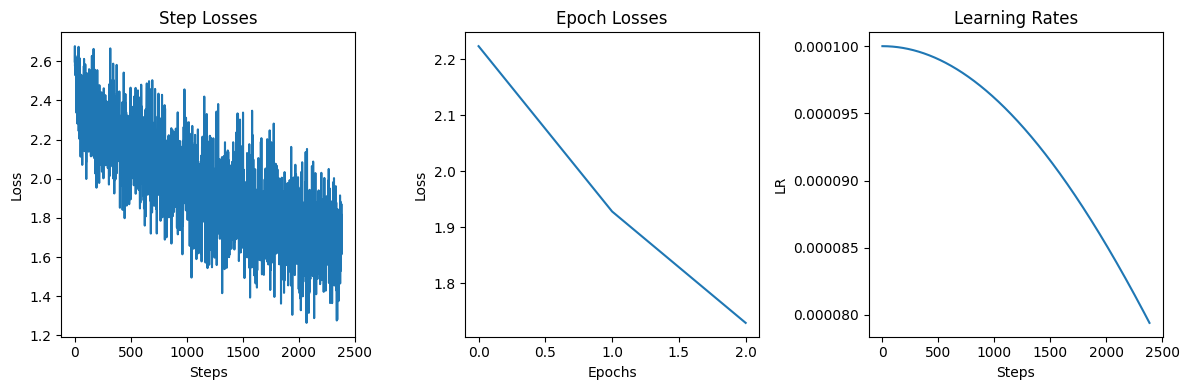

In [ ]:
vanilla_classifier = VanillaClassifier(
    class_num=df['donor_id'].unique().shape[0],  # Number of unique classes
    dropout=0.3,
)

optimizer = torch.optim.Adam(vanilla_classifier.parameters(), lr=1e-4)
ce_loss = torch.nn.CrossEntropyLoss()  # Main task loss
bce_loss = torch.nn.BCEWithLogitsLoss()  # Adversarial loss for sex prediction
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10 * len(cell_dataloader))

# Create the classification trainer with adversarial support
trainer = VanillaTrainer(
    model=vanilla_classifier,
    optimizer=optimizer,
    loss_fn=ce_loss,
    scheduler=scheduler,
)

# train the model
train_metrics = trainer.train(
    cell_dataloader,
    num_epochs=10,
    # val_loader=test_dataloader,
)

# After training, you can visualize both main and adversarial metrics
trainer.plot_training_metrics(save_path="./logs/classification/vanilla_training_results.png")

  0%|          | 0/199 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.45      0.21      0.29       439
           1       0.33      0.68      0.45       480
           2       0.36      0.12      0.18       288
           3       0.63      0.60      0.61       193
           4       0.46      0.59      0.51       663
           5       0.46      0.27      0.34       381
           6       0.65      0.61      0.63       687
           7       0.39      0.25      0.31       569
           8       0.44      0.60      0.51       544
           9       0.50      0.45      0.47       412
          10       0.12      0.02      0.03       201
          11       0.55      0.21      0.30       332
          12       0.47      0.58      0.52       359
          13       0.62      0.83      0.71       808

    accuracy                           0.49      6356
   macro avg       0.46      0.43      0.42      6356
weighted avg       0.48      0.49      0.46      6356

Model Accuracy: 48.537%


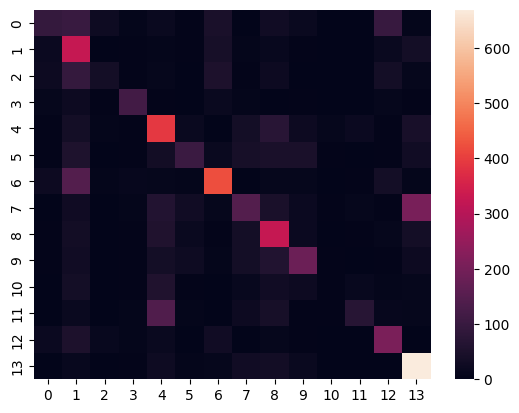

In [13]:
y_pred, y_true = inference(
    vanilla_classifier,
    test_dataloader,
)
y_pred = F.softmax(y_pred, dim=1).argmax(1)

print(classification_report(y_true, y_pred, zero_division=0))
print('Model Accuracy: {:.3f}%'.format(accuracy_score(y_true, y_pred) * 100))

sns.heatmap(confusion_matrix(y_true, y_pred), 
            label=[class_mapping[i] for i in range(len(class_mapping))])
plt.show()

Based on my observations multimodal model works slightly better than vanilla classifier due to its architecture that it can capture more complex patterns and learn more information. However, key point here is that the the vanilla classifier due to its less number of parameters and less complex layers it converges much faster than the multimodal model.